In [1]:
# prompt: automatic reload

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import sys

import numpy as np
import pandas as pd

logging.basicConfig(level=logging.INFO)

In [3]:
import torch
torch.__version__

'2.6.0+cu124'

This notebook demonstrates finetuning Zoobot.

Finetuning means adapting a model pretrained on a large amount of data (here, many Galaxy Zoo answers) to solve a new problem using a small amount of new data.

We follow these steps:
- Install Zoobot (PyTorch version)
- Download the data to finetune on, starting from that checkpoint and the data to finetune on (ring images and ring label catalog)
- Download a pretrained checkpoint from HuggingFace
- Configure and run the finetuning

For standalone script examples, see zoobot/pytorch/examples/finetuning



---



*Retraining will be quite slow unless you use a GPU. Use the top
toolbar: Runtime- > Change Runtime -> GPU*

---

## Install Zoobot

In [ ]:
!pip install zoobot[pytorch-colab] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



If you will get the error below later:
> AttributeError: module 'pkg_resources._vendor.packaging' has no attribute 'requirements'

then restart the runtime and run it again - press the button just above.

In [4]:
!ls /content

ls: cannot access '/content': No such file or directory


In [ ]:
# colab is weird sometimes and erratically needs this hack to make imports work
# no need to do this locally
sys.path.append('/content/galaxy-datasets')
sys.path.append('/content/zoobot')
sys.path.append('/content/zoobot/pytorch')


Now we're set up and can start using Zoobot.

## Download Catalogs of Images and Labels

Each catalog should be a dataframe with columns of "id_str", "file_loc", and any labels.

Here I'm using galaxy-datasets to download some premade data - check it out for examples.

In [ ]:
# galaxy-datasets is a dependency of Zoobot.
# It has code handling downloading and loading data.
from galaxy_datasets import demo_rings

data_dir = '/content/demo_rings'

train_catalog, _ = demo_rings(root=data_dir, download=True, train=True)
test_catalog, _ = demo_rings(root=data_dir, download=True, train=False)

Using downloaded and verified file: /content/demo_rings/demo_rings_train_catalog.parquet
Using downloaded and verified file: /content/demo_rings/demo_rings_test_catalog.parquet
Using downloaded and verified file: /content/demo_rings/demo_rings_images.tar.gz
Extracting /content/demo_rings/demo_rings_images.tar.gz to /content/demo_rings
Using downloaded and verified file: /content/demo_rings/demo_rings_train_catalog.parquet
Using downloaded and verified file: /content/demo_rings/demo_rings_test_catalog.parquet
Using downloaded and verified file: /content/demo_rings/demo_rings_images.tar.gz
Extracting /content/demo_rings/demo_rings_images.tar.gz to /content/demo_rings


In [ ]:
train_catalog.head()

,id_str,ring_fraction,subfolder,filename,ring,file_loc
0,487483_3522,0.714286,487483,487483_3522.jpg,True,/content/demo_rings/images/487483/487483_3522.jpg
1,287521_2026,0.666667,287521,287521_2026.jpg,True,/content/demo_rings/images/287521/287521_2026.jpg
2,519986_112,0.583333,519986,519986_112.jpg,True,/content/demo_rings/images/519986/519986_112.jpg
3,362959_3369,0.800000,362959,362959_3369.jpg,True,/content/demo_rings/images/362959/362959_3369.jpg
4,426137_3385,0.700000,426137,426137_3385.jpg,True,/content/demo_rings/images/426137/426137_3385.jpg


The catalog must have:
- Column(s) with your labels e.g. `ring`.
- `id_str` to identify each row. Can be anything unique.
- `file_loc` column with paths to each image (.jpg, .png and .fits are supported - see the docs)


For multiple classes, use multiple columns with one-hot labels. For example:

In [ ]:
example_multiclass_labels = pd.DataFrame([[0,1,0],[1,0,0],[0, 0,1]], columns=['class_a', 'class_b', 'class_c'])
example_multiclass_labels # just to illustrate. not used here as we're doing binary classification.

,class_a,class_b,class_c
0,0,1,0
1,1,0,0
2,0,0,1


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(catalog, test_size=0.2, random_state=42, stratify=catalog[label_cols])
print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

In [26]:
import pandas as pd

catalog = pd.read_csv('galaxies-rgb.csv')
catalog = catalog[catalog.imagetype=='RGB']
catalog['file_loc'] = catalog.apply(lambda x: 'datasets/'+x.datasetfolder+'/'+x.file ,axis=1)
catalog['galaxy'] = catalog['galaxy'].astype(bool)

label_cols = ['galaxy']

catalog.head()

,folder,subfolder,file,imagetype,galaxy,ra,dec,zone,type,suffix,datasetfolder,id_str,file_loc
0,Galaxias/10450_0145,RGB_10450_0145,"104.7263830,2.0560720_10450_0145_RGB-composite...",RGB,True,104.726383,2.056072,10450_0145,RGB-composite,jpeg,galaxies-rgb/galaxy,"104.7263830,2.0560720_10450_0145","datasets/galaxies-rgb/galaxy/104.7263830,2.056..."
1,Galaxias/10450_0145,RGB_10450_0145,"104.1504793,1.3987231_10450_0145_RGB-composite...",RGB,True,104.150479,1.398723,10450_0145,RGB-composite,jpeg,galaxies-rgb/galaxy,"104.1504793,1.3987231_10450_0145","datasets/galaxies-rgb/galaxy/104.1504793,1.398..."
2,Galaxias/10450_0145,RGB_10450_0145,"104.9237340,1.5302104_10450_0145_RGB-composite...",RGB,True,104.923734,1.530210,10450_0145,RGB-composite,jpeg,galaxies-rgb/galaxy,"104.9237340,1.5302104_10450_0145","datasets/galaxies-rgb/galaxy/104.9237340,1.530..."
3,Galaxias/10450_0145,RGB_10450_0145,"104.7788009,1.1385662_10450_0145_RGB-composite...",RGB,True,104.778801,1.138566,10450_0145,RGB-composite,jpeg,galaxies-rgb/galaxy,"104.7788009,1.1385662_10450_0145","datasets/galaxies-rgb/galaxy/104.7788009,1.138..."
4,Galaxias/10450_0145,RGB_10450_0145,"104.3578369,1.5539122_10450_0145_RGB-composite...",RGB,True,104.357837,1.553912,10450_0145,RGB-composite,jpeg,galaxies-rgb/galaxy,"104.3578369,1.5539122_10450_0145","datasets/galaxies-rgb/galaxy/104.3578369,1.553..."


For binary classification, a single column with boolean or integer labels is enough. We'll define `label_cols=["ring"]` below and pass it to our dataloader later.



Why a list? To support more complicated labels, Zoobot expects a list of columns. A list with one element works fine for classification.

Optional: check `id_str` is unique. No galaxy should appear twice.

In [27]:
catalog[catalog.id_str=='None,None_None']

,folder,subfolder,file,imagetype,galaxy,ra,dec,zone,type,suffix,datasetfolder,id_str,file_loc


In [28]:
from sklearn.model_selection import train_test_split

train_catalog, test_catalog = train_test_split(catalog, test_size=0.2, random_state=42, stratify=catalog[label_cols])
print(f"Training set size: {len(train_catalog)}")
print(f"Testing set size: {len(test_catalog)}")

Training set size: 1140
Testing set size: 285


In [189]:
train_catalog.to_csv('train_catalog.csv', index=True)
test_catalog.to_csv('test_catalog.csv', index=True)

catalog['train'] = 1
catalog.loc[test_catalog.index,'train'] = 0
catalog.to_csv('catalog.csv', index=True)

In [29]:
all_id_strs = list(train_catalog['id_str']) + list(test_catalog['id_str'])
assert pd.Series(all_id_strs).value_counts().max() == 1

Optional: check that all images load correctly.

Worth checking once, and especially if you get "InvalidArgumentError" when running the model below.

In [30]:
assert all([os.path.isfile(loc) for loc in train_catalog['file_loc']])

In [33]:
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule

datamodule = GalaxyDataModule(
  label_cols=label_cols,  # specifying which columns to load as labels with `label_cols`
  catalog=train_catalog,
  batch_size=32,
  resize_after_crop=224,  # the size of the images input to the model
  num_workers=2,  # sets the parallelism for loading data. 2 works well on colab.
  greyscale=False  # Most Zoobot checkpoints expect color images
)

INFO:root:Num workers: 2
INFO:root:Prefetch factor: 4
INFO:root:Using albumentations transform for augmentations
INFO:root:Using basic albumentations transforms for augmentations


In [34]:
# just to demonstrate what datamodule returns. you don't need to do this.
datamodule.setup()
for batch in datamodule.train_dataloader():
  images = batch[0]
  labels = batch[1]
  print(images.min(), images.max(), images.shape)
  print(labels)
  break

tensor(0.) tensor(1.) torch.Size([32, 3, 224, 224])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.])


## Download Pretrained Model

Download the pretrained model checkpoint from HuggingFace.

Many popular architectures are available. See the collection [here](https://huggingface.co/collections/mwalmsley/zoobot-encoders-65fa14ae92911b173712b874) and the Zoobot [docs](https://zoobot.readthedocs.io/en/latest/data_notes.html). I suggest starting with ConvNeXT-Nano, which is small yet high-performing.



In [35]:
from zoobot.pytorch.training.finetune import FinetuneableZoobotClassifier

model = FinetuneableZoobotClassifier(
    # arguments for any FinetuneableZoobot class
    # there are many options for customizing finetuning. See the FinetuneableZoobotAbstract docstring.
    name='hf_hub:mwalmsley/zoobot-encoder-convnext_nano',
    n_blocks=5,  # Finetune this many blocks. Set 0 for only the head. Set e.g. 1, 2 to finetune deeper (5 max for convnext).
    learning_rate=1e-5,  # use a low learning rate
    lr_decay=0.5,  # reduce the learning rate from lr to lr^0.5 for each block deeper in the network

    # arguments specific to FinetuneableZoobotClassifier
    num_classes=2
)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (mwalmsley/zoobot-encoder-convnext_nano)
INFO:root:Using classification head and cross-entropy loss
INFO:root:num_classes: 2
INFO:root:Using binary classification


# Now the Actual Finetuning

In [36]:
from zoobot.pytorch.training.finetune import get_trainer

# TODO you can update these paths to suit own data
save_dir = os.path.join('finetune_binary_classification')

trainer = get_trainer(save_dir, accelerator='auto', devices='auto', max_epochs=30)
trainer.fit(model, datamodule)
# should reach about 85% accuracy, loss of about 0.40

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/rmegret/miniconda3/envs/zoobot/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:root:Encoder architecture to finetune: <class 'timm.models.convnext.ConvNeXt'>
INFO:root:possible blocks to tune: 5
I

/home/rmegret/miniconda3/envs/zoobot/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 24/24 [01:13<00:00,  0.33it/s, v_num=0, finetuning/val_loss=0.636, finetuning/val_acc=0.649, finetuning/train_loss=0.731, finetuning/train_acc=0.529]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 24: 'finetuning/val_loss' reached 0.63635 (best 0.63635), saving model to '/home/rmegret/galaxy/finetune_binary_classification/checkpoints/0.ckpt' as top 1


Epoch 1: 100%|██████████| 24/24 [01:05<00:00,  0.36it/s, v_num=0, finetuning/val_loss=0.627, finetuning/val_acc=0.570, finetuning/train_loss=0.660, finetuning/train_acc=0.616]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 48: 'finetuning/val_loss' reached 0.62711 (best 0.62711), saving model to '/home/rmegret/galaxy/finetune_binary_classification/checkpoints/1.ckpt' as top 1


Epoch 2: 100%|██████████| 24/24 [01:05<00:00,  0.36it/s, v_num=0, finetuning/val_loss=0.613, finetuning/val_acc=0.640, finetuning/train_loss=0.639, finetuning/train_acc=0.632]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 72: 'finetuning/val_loss' reached 0.61291 (best 0.61291), saving model to '/home/rmegret/galaxy/finetune_binary_classification/checkpoints/2.ckpt' as top 1


Epoch 3: 100%|██████████| 24/24 [01:05<00:00,  0.36it/s, v_num=0, finetuning/val_loss=0.589, finetuning/val_acc=0.640, finetuning/train_loss=0.607, finetuning/train_acc=0.676]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 96: 'finetuning/val_loss' reached 0.58873 (best 0.58873), saving model to '/home/rmegret/galaxy/finetune_binary_classification/checkpoints/3.ckpt' as top 1


Epoch 4: 100%|██████████| 24/24 [01:05<00:00,  0.36it/s, v_num=0, finetuning/val_loss=0.578, finetuning/val_acc=0.649, finetuning/train_loss=0.600, finetuning/train_acc=0.674]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 120: 'finetuning/val_loss' reached 0.57801 (best 0.57801), saving model to '/home/rmegret/galaxy/finetune_binary_classification/checkpoints/4.ckpt' as top 1


Epoch 5: 100%|██████████| 24/24 [01:39<00:00,  0.24it/s, v_num=0, finetuning/val_loss=0.595, finetuning/val_acc=0.658, finetuning/train_loss=0.576, finetuning/train_acc=0.691]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 144: 'finetuning/val_loss' was not in top 1


Epoch 6: 100%|██████████| 24/24 [02:05<00:00,  0.19it/s, v_num=0, finetuning/val_loss=0.573, finetuning/val_acc=0.649, finetuning/train_loss=0.564, finetuning/train_acc=0.704]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 168: 'finetuning/val_loss' reached 0.57287 (best 0.57287), saving model to '/home/rmegret/galaxy/finetune_binary_classification/checkpoints/6.ckpt' as top 1


Epoch 7: 100%|██████████| 24/24 [02:03<00:00,  0.19it/s, v_num=0, finetuning/val_loss=0.529, finetuning/val_acc=0.693, finetuning/train_loss=0.534, finetuning/train_acc=0.736]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 192: 'finetuning/val_loss' reached 0.52913 (best 0.52913), saving model to '/home/rmegret/galaxy/finetune_binary_classification/checkpoints/7.ckpt' as top 1


Epoch 8: 100%|██████████| 24/24 [02:05<00:00,  0.19it/s, v_num=0, finetuning/val_loss=0.575, finetuning/val_acc=0.684, finetuning/train_loss=0.524, finetuning/train_acc=0.736]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 216: 'finetuning/val_loss' was not in top 1


Epoch 9: 100%|██████████| 24/24 [02:02<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.548, finetuning/val_acc=0.693, finetuning/train_loss=0.535, finetuning/train_acc=0.711]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 240: 'finetuning/val_loss' was not in top 1


Epoch 10: 100%|██████████| 24/24 [02:01<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.561, finetuning/val_acc=0.711, finetuning/train_loss=0.510, finetuning/train_acc=0.737]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 264: 'finetuning/val_loss' was not in top 1


Epoch 11: 100%|██████████| 24/24 [02:00<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.555, finetuning/val_acc=0.702, finetuning/train_loss=0.504, finetuning/train_acc=0.754]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 288: 'finetuning/val_loss' was not in top 1


Epoch 12: 100%|██████████| 24/24 [02:00<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.552, finetuning/val_acc=0.719, finetuning/train_loss=0.480, finetuning/train_acc=0.773]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 312: 'finetuning/val_loss' was not in top 1


Epoch 13: 100%|██████████| 24/24 [02:00<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.528, finetuning/val_acc=0.711, finetuning/train_loss=0.458, finetuning/train_acc=0.792]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 336: 'finetuning/val_loss' reached 0.52806 (best 0.52806), saving model to '/home/rmegret/galaxy/finetune_binary_classification/checkpoints/13.ckpt' as top 1


Epoch 14: 100%|██████████| 24/24 [02:00<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.529, finetuning/val_acc=0.719, finetuning/train_loss=0.447, finetuning/train_acc=0.793]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 360: 'finetuning/val_loss' was not in top 1


Epoch 15: 100%|██████████| 24/24 [02:01<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.573, finetuning/val_acc=0.702, finetuning/train_loss=0.476, finetuning/train_acc=0.784]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 384: 'finetuning/val_loss' was not in top 1


Epoch 16: 100%|██████████| 24/24 [02:02<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.535, finetuning/val_acc=0.693, finetuning/train_loss=0.437, finetuning/train_acc=0.781]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 408: 'finetuning/val_loss' was not in top 1


Epoch 17: 100%|██████████| 24/24 [02:02<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.534, finetuning/val_acc=0.737, finetuning/train_loss=0.448, finetuning/train_acc=0.790]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 432: 'finetuning/val_loss' was not in top 1


Epoch 18: 100%|██████████| 24/24 [02:02<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.550, finetuning/val_acc=0.754, finetuning/train_loss=0.405, finetuning/train_acc=0.812]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 456: 'finetuning/val_loss' was not in top 1


Epoch 19: 100%|██████████| 24/24 [02:01<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.602, finetuning/val_acc=0.719, finetuning/train_loss=0.402, finetuning/train_acc=0.824]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 480: 'finetuning/val_loss' was not in top 1


Epoch 20: 100%|██████████| 24/24 [02:01<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.550, finetuning/val_acc=0.737, finetuning/train_loss=0.376, finetuning/train_acc=0.839]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 504: 'finetuning/val_loss' was not in top 1


Epoch 21: 100%|██████████| 24/24 [01:20<00:00,  0.30it/s, v_num=0, finetuning/val_loss=0.552, finetuning/val_acc=0.684, finetuning/train_loss=0.392, finetuning/train_acc=0.819]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 528: 'finetuning/val_loss' was not in top 1


Epoch 22: 100%|██████████| 24/24 [02:00<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.542, finetuning/val_acc=0.746, finetuning/train_loss=0.388, finetuning/train_acc=0.822]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 552: 'finetuning/val_loss' was not in top 1


Epoch 23: 100%|██████████| 24/24 [02:02<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.507, finetuning/val_acc=0.763, finetuning/train_loss=0.365, finetuning/train_acc=0.844]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 576: 'finetuning/val_loss' reached 0.50716 (best 0.50716), saving model to '/home/rmegret/galaxy/finetune_binary_classification/checkpoints/23.ckpt' as top 1


Epoch 24: 100%|██████████| 24/24 [02:02<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.541, finetuning/val_acc=0.754, finetuning/train_loss=0.350, finetuning/train_acc=0.846]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 600: 'finetuning/val_loss' was not in top 1


Epoch 25: 100%|██████████| 24/24 [02:00<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.595, finetuning/val_acc=0.702, finetuning/train_loss=0.314, finetuning/train_acc=0.857]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 624: 'finetuning/val_loss' was not in top 1


Epoch 26: 100%|██████████| 24/24 [02:01<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.532, finetuning/val_acc=0.746, finetuning/train_loss=0.325, finetuning/train_acc=0.858]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 648: 'finetuning/val_loss' was not in top 1


Epoch 27: 100%|██████████| 24/24 [02:00<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.584, finetuning/val_acc=0.737, finetuning/train_loss=0.307, finetuning/train_acc=0.874]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 672: 'finetuning/val_loss' was not in top 1


Epoch 28: 100%|██████████| 24/24 [02:00<00:00,  0.20it/s, v_num=0, finetuning/val_loss=0.578, finetuning/val_acc=0.702, finetuning/train_loss=0.310, finetuning/train_acc=0.859]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 696: 'finetuning/val_loss' was not in top 1


Epoch 29: 100%|██████████| 24/24 [1:22:21<00:00,  0.00it/s, v_num=0, finetuning/val_loss=0.670, finetuning/val_acc=0.702, finetuning/train_loss=0.288, finetuning/train_acc=0.872]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 720: 'finetuning/val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 24/24 [1:22:21<00:00,  0.00it/s, v_num=0, finetuning/val_loss=0.670, finetuning/val_acc=0.702, finetuning/train_loss=0.288, finetuning/train_acc=0.872]


In [37]:
# now we can load the best checkpoint and make predictions
best_checkpoint = trainer.checkpoint_callback.best_model_path
finetuned_model = FinetuneableZoobotClassifier.load_from_checkpoint(best_checkpoint)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (mwalmsley/zoobot-encoder-convnext_nano)
INFO:root:Using classification head and cross-entropy loss
INFO:root:num_classes: 2
INFO:root:Using binary classification


In [38]:
from zoobot.pytorch.predictions import predict_on_catalog

_ = predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  n_samples=1,
  # CAREFUL! For classification, we unpack a single column like [1, 0, 1, 2, ...] into N classes automatically
  # but when making predictions, we make a prediction per class, so (unlike for training) this prediction `label_cols` needs n_classes entries
  # e.g. [class_for_label_0, class_for_label_1, ...
  label_cols=['not_galaxy', 'galaxy'],  # name the output columns
  save_loc=os.path.join(save_dir, 'finetuned_predictions.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2, 'batch_size': 32, 'greyscale': False},
)

INFO:root:Num workers: 2
INFO:root:Prefetch factor: 4
INFO:root:Using albumentations transform for augmentations
INFO:root:Using basic albumentations transforms for augmentations
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:root:Beginning predictions
INFO:root:Starting at: 2025-03-20 17:46:40
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:04<00:00,  2.24it/s]


INFO:root:Predictions complete - (285, 2, 1)
INFO:root:Saving predictions to finetune_binary_classification/finetuned_predictions.csv
INFO:root:Predictions saved to finetune_binary_classification/finetuned_predictions.csv
INFO:root:Completed at: 2025-03-20 17:46:45
INFO:root:Time elapsed: 0:00:05.876515


Let's quickly check if they're any good:

In [39]:
predictions = pd.read_csv(os.path.join(save_dir, 'finetuned_predictions.csv'))
print(predictions.shape[0])
predictions.head()

285


,id_str,not_galaxy_pred,galaxy_pred
0,"105.9618018,0.9788696_10550_0145",0.420216,0.579784
1,"104.3868797,1.4644139_10450_0145",0.496418,0.503582
2,"102.9923872,1.3555300_10250_0145",0.590704,0.409296
3,"104.4203546,2.2980808_10450_0270",0.903391,0.096609
4,"105.9727592,0.7402849_10550_0020",0.005112,0.994888


In [40]:

predictions = pd.merge(predictions, test_catalog[['id_str', 'file_loc', 'galaxy']])
predictions.head()

,id_str,not_galaxy_pred,galaxy_pred,file_loc,galaxy
0,"105.9618018,0.9788696_10550_0145",0.420216,0.579784,"datasets/galaxies-rgb/no_galaxy/105.9618018,0....",False
1,"104.3868797,1.4644139_10450_0145",0.496418,0.503582,"datasets/galaxies-rgb/galaxy/104.3868797,1.464...",True
2,"102.9923872,1.3555300_10250_0145",0.590704,0.409296,"datasets/galaxies-rgb/no_galaxy/102.9923872,1....",False
3,"104.4203546,2.2980808_10450_0270",0.903391,0.096609,"datasets/galaxies-rgb/no_galaxy/104.4203546,2....",False
4,"105.9727592,0.7402849_10550_0020",0.005112,0.994888,"datasets/galaxies-rgb/galaxy/105.9727592,0.740...",True


In [55]:
#import seaborn as sns
import matplotlib.pyplot as plt

In [179]:
print('Accuracy:', np.mean(np.around(predictions['galaxy_pred']) == predictions['galaxy']))

Accuracy: 0.7157894736842105


Text(0.5, 0, 'predicted score')

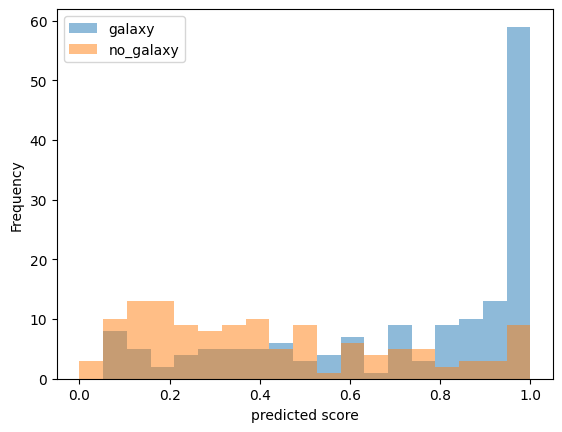

In [62]:
pp = predictions.copy()
pp['galaxy']=pp['galaxy'].astype(float)
pp[pp.galaxy==1]['galaxy_pred'].rename('galaxy').plot.hist(bins=np.linspace(0,1, 20), alpha=0.5);
pp[pp.galaxy==0]['galaxy_pred'].rename('no_galaxy').plot.hist(bins=np.linspace(0,1, 20), alpha=0.5);
plt.legend()
plt.xlabel('predicted score')

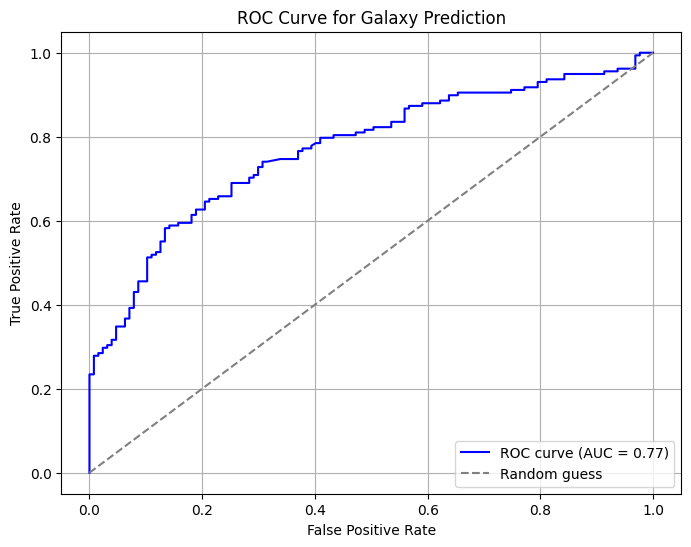

In [177]:
from sklearn.metrics import roc_curve, auc

true_labels = predictions['galaxy'].astype(int)  # Convert boolean to integer
predicted_probs = predictions['galaxy_pred']

fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Galaxy Prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [178]:
print(train_catalog.shape[0])
print(test_catalog.shape[0])
print(predictions.shape[0])

1140
285
285


In [180]:
# Do same on training to sort out difficulty levels

_ = predict_on_catalog.predict(
  train_catalog,
  finetuned_model,
  n_samples=1,
  # CAREFUL! For classification, we unpack a single column like [1, 0, 1, 2, ...] into N classes automatically
  # but when making predictions, we make a prediction per class, so (unlike for training) this prediction `label_cols` needs n_classes entries
  # e.g. [class_for_label_0, class_for_label_1, ...
  label_cols=['not_galaxy', 'galaxy'],  # name the output columns
  save_loc=os.path.join(save_dir, 'finetuned_predictions_train_dataset.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2, 'batch_size': 32, 'greyscale': False},
)

INFO:root:Num workers: 2
INFO:root:Prefetch factor: 4
INFO:root:Using albumentations transform for augmentations
INFO:root:Using basic albumentations transforms for augmentations
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:root:Beginning predictions
INFO:root:Starting at: 2025-03-21 14:48:25
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]


INFO:root:Predictions complete - (1140, 2, 1)
INFO:root:Saving predictions to finetune_binary_classification/finetuned_predictions_train_dataset.csv
INFO:root:Predictions saved to finetune_binary_classification/finetuned_predictions_train_dataset.csv
INFO:root:Completed at: 2025-03-21 14:48:45
INFO:root:Time elapsed: 0:00:20.014797


In [187]:
predictions_training = pd.read_csv(os.path.join(save_dir, 'finetuned_predictions_train_dataset.csv'))
print(predictions_training.shape[0])

predictions_training = pd.merge(predictions_training, train_catalog[['id_str', 'file_loc', 'galaxy']])
print(predictions_training.shape[0])

predictions_training.head()

1140
1140


,id_str,not_galaxy_pred,galaxy_pred,file_loc,galaxy
0,"102.5755107,2.8637477_10250_0270",0.001637,0.998363,"datasets/galaxies-rgb/galaxy/102.5755107,2.863...",True
1,"102.8838975,2.8731895_10250_0270",0.019820,0.980180,"datasets/galaxies-rgb/galaxy/102.8838975,2.873...",True
2,"101.8885211,2.8942992_10150_0270",0.752364,0.247636,"datasets/galaxies-rgb/no_galaxy/101.8885211,2....",False
3,"102.6217566,3.0810773_10250_0270",0.528298,0.471702,"datasets/galaxies-rgb/galaxy/102.6217566,3.081...",True
4,"104.6644177,0.1998000_10450_0020",0.176153,0.823847,"datasets/galaxies-rgb/galaxy/104.6644177,0.199...",True


In [190]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_rings(df, nrows=None, ncols=5):
  # little utility function to visualise galaxies and our ring labels/predictions

  N = df.shape[0]
  #print(N)
  if (nrows is None):
    nrows = (N+ncols-1)//ncols
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
  axes = axes.ravel()
  for n in range(ncols*nrows):
    axes[n].axis('off')
    if (n>=N): continue;
    galaxy = df.iloc[n]

    im = Image.open(galaxy['file_loc'])
    axes[n].imshow(im)

    correct = np.around(galaxy['galaxy_pred']) == galaxy['galaxy']
    if correct:
      color = 'g'
    else:
      color = 'r'
    axes[n].text(20, 30, 'Pred: {:.2f}'.format(galaxy['galaxy_pred']), color=color)
    axes[n].text(20, 60, 'Label: {}'.format(galaxy['galaxy']), color=color)
    axes[n].plot([130,230],[20,20],color=color)
    axes[n].plot([130+100*galaxy['galaxy']],[25],'^',color='g')
    axes[n].plot([130+100*galaxy['galaxy_pred']],[20],'o',color=color)
    axes[n].text(130, 40, 'Err {:.2f}'.format(abs(galaxy['galaxy']-galaxy['galaxy_pred'])), color=color)
    axes[n].text(10,240, galaxy['id_str'], color=color, size=7)
    axes[n].set_title(f"#{int(galaxy.name)}: {galaxy['id_str']}", size=7)
  return fig, axes

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

pdf_filename = "predictions_test.pdf"

predictions_sorted = predictions.sort_values('galaxy_pred', ascending=False)
N = predictions_sorted.shape[0]
n_per_page = 25
k_pages = (N+n_per_page-1)//n_per_page
#k_pages = 1
with PdfPages(pdf_filename) as pdf:
  for k in tqdm(range(k_pages)):
    n1 = k*n_per_page
    fig, axes = show_rings(predictions_sorted.iloc[n1:], nrows=5, ncols=8)
    #print(top_5_predictions['id_str'])
    fig.suptitle(f'TEST DATA: Sorted by prediction score - Page {k+1}/{k_pages} - {n1}..{min(N,n1+n_per_page-1)}/0..{N-1}', fontsize=16)
    fig.tight_layout()
    pdf.savefig()
    plt.close()

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:42<00:00,  3.55s/it]


In [ ]:
pdf_filename = "predictions_test_error.pdf"

p_df = predictions.copy()
p_df['pred_error'] = np.abs(p_df['galaxy']-p_df['galaxy_pred'])
predictions_sorted = p_df.sort_values('pred_error', ascending=False)
N = predictions_sorted.shape[0]
n_per_page = 25
k_pages = (N+n_per_page-1)//n_per_page
#k_pages = 1
with PdfPages(pdf_filename) as pdf:
  for k in tqdm(range(k_pages)):
    n1 = k*n_per_page
    fig, axes = show_rings(predictions_sorted.iloc[n1:], nrows=5, ncols=8)
    #print(top_5_predictions['id_str'])
    fig.suptitle(f'TEST DATA: Sorted by prediction error - {k+1}/{k_pages} - {n1}..{min(N,n1+n_per_page-1)}/0..{N-1}', fontsize=16)
    fig.tight_layout()
    pdf.savefig()
    plt.close()

100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


In [188]:
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

# Save predictions on training sorted by score

pdf_filename = "predictions_training.pdf"

predictions_sorted = predictions_training.sort_values('galaxy_pred', ascending=False)
N = predictions_sorted.shape[0]
n_per_page = 25
k_pages = (N+n_per_page-1)//n_per_page
#k_pages = 1
with PdfPages(pdf_filename) as pdf:
  for k in tqdm(range(k_pages)):
    n1 = k*n_per_page
    fig, axes = show_rings(predictions_sorted.iloc[n1:], nrows=5, ncols=8)
    #print(top_5_predictions['id_str'])
    fig.suptitle(f'TRAIN DATA - Sorted by prediction score - Page {k+1}/{k_pages} - {n1}..{min(N,n1+n_per_page-1)}/0..{N-1}', fontsize=16)
    fig.tight_layout()
    pdf.savefig()
    plt.close()

  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [03:10<00:00,  4.14s/it]


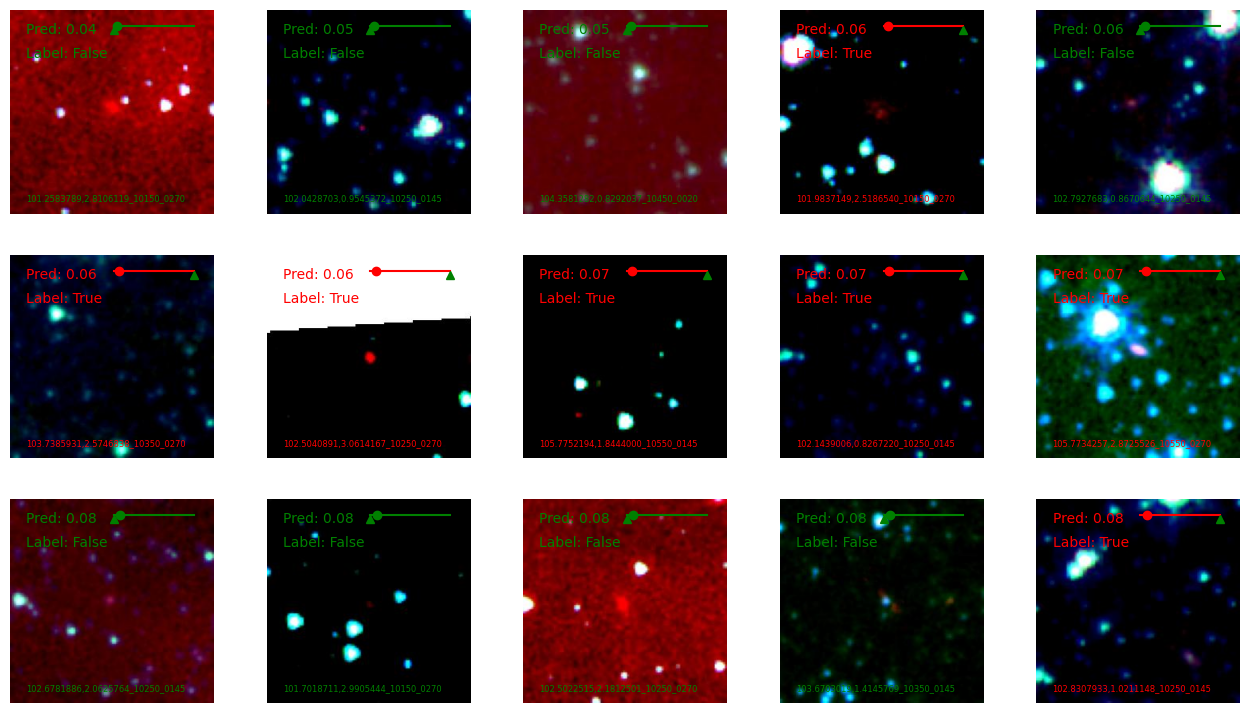

In [134]:
bottom_5_predictions = predictions.sort_values('galaxy_pred', ascending=True)
show_rings(bottom_5_predictions, nrows = 3)

82     103.8003187,1.2430635_10350_0145
182    102.5040891,3.0614167_10250_0270
228    105.5467757,1.9709162_10550_0145
264    106.0356981,2.3671322_10550_0270
138    102.5734550,1.8575036_10250_0145
Name: id_str, dtype: object


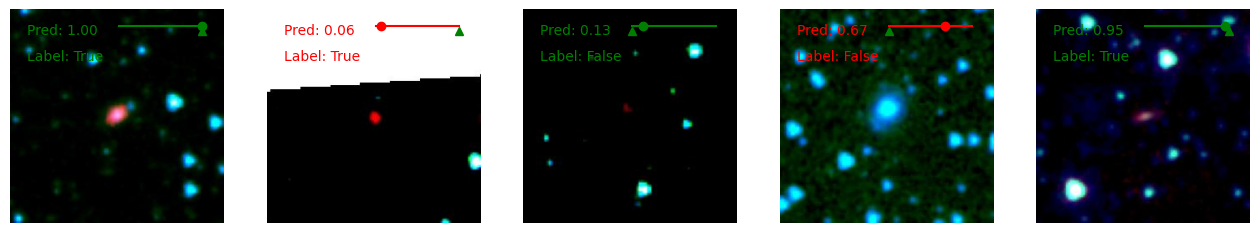

In [117]:
random_predictions = predictions.sample(5)
print(random_predictions['id_str'])
show_rings(random_predictions, nrows=1)

159    102.2991659,1.6730745_10250_0145
263    102.9492071,0.8625303_10250_0145
32     104.3492495,0.1497493_10450_0020
17     104.8571809,2.8171977_10450_0270
283    103.3787916,2.6050774_10350_0270
Name: id_str, dtype: object


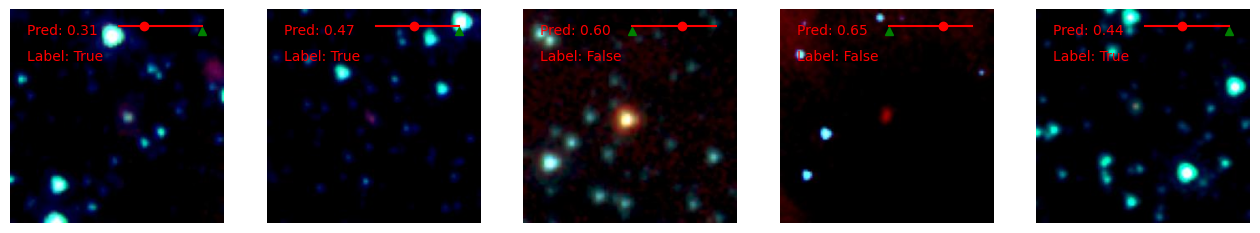

In [93]:
wrong_predictions = predictions.loc[(predictions['galaxy_pred']>0.5) != predictions['galaxy']]
random_predictions = wrong_predictions.sample(5)
print(random_predictions['id_str'])
show_rings(random_predictions)

Pretty good given only a couple of hundred examples for each class.


## Saving predictions to HDF5

By the way - you can also save predictions to hdf5. This is useful for saving higher-dimensional outputs (e.g. representations or multiple forward passes).

In [ ]:
from zoobot.pytorch.predictions import predict_on_catalog

predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  n_samples=5,  # 5 forward passes with MC Dropout and different random augs
  label_cols=['not_galaxy', 'galaxy'],
  save_loc=os.path.join(save_dir, 'finetuned_predictions.hdf5'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2, 'batch_size': 32, 'greyscale': False},
)

import h5py

with h5py.File(os.path.join(save_dir, 'finetuned_predictions.hdf5')) as f:
  print(f.keys())
  print(f['predictions'].shape)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<KeysViewHDF5 ['id_str', 'label_cols', 'predictions']>
(200, 2, 5)
